In [1]:
import pandas as pd
import vectorbt as vbt
import quantstats as qs

In [15]:
import os

os.environ["OMP_NUM_THREADS"] = "1"


In [2]:
台指資料 = pd.read_table(rf'.\台指資料.txt',encoding = 'ANSI').iloc[1:].drop(columns = ['期貨名稱','簡稱']).set_index('日期').astype(float)
台指資料.index = pd.to_datetime(台指資料.index)
close_price = 台指資料['收盤價']
open_price = 台指資料['開盤價']

In [3]:
三大法人未平倉 = pd.read_table(rf'.\三大法人未平倉.txt',encoding = 'ANSI').iloc[1:].drop(columns = ['身份別','簡稱']).set_index('年月日').astype(float)
三大法人未平倉.index = pd.to_datetime(三大法人未平倉.index)
三大法人未平倉 = 三大法人未平倉.groupby('年月日').sum()

In [4]:
未平倉合約數 = pd.read_table(rf'.\未平倉合約數.txt',encoding = 'ANSI').iloc[1:].drop(columns = ['期貨名稱','簡稱']).set_index('日期')['未平倉合約數'].astype(float)
未平倉合約數.index = pd.to_datetime(未平倉合約數.index)
未平倉合約數*=2

In [5]:
散戶多單未平倉 = 未平倉合約數 - 三大法人未平倉['多方未平倉口數']
散戶空單未平倉 = 未平倉合約數 - 三大法人未平倉['空方未平倉口數']
小台散戶多空比 = ((散戶多單未平倉 - 散戶空單未平倉) / 未平倉合約數).dropna()

In [6]:
小台散戶多空比

2007-07-02   -0.198159
2007-07-03   -0.246656
2007-07-04   -0.229809
2007-07-05   -0.232500
2007-07-06   -0.220324
                ...   
2023-07-14   -0.130935
2023-07-17   -0.086659
2023-07-18   -0.078472
2023-07-19    0.212458
2023-07-20    0.016956
Length: 3955, dtype: float64

In [7]:
def get_fitness(long_param,short_param,entry_price,in_sample):
    qs.extend_pandas()
    pf = vbt.Portfolio.from_signals(open_price.shift(-1).loc[小台散戶多空比.loc[:in_sample].index],
                                    entries = 小台散戶多空比.loc[:in_sample] < -(long_param/100),
                                    exits = 小台散戶多空比.loc[:in_sample] > (long_param/100),
                                    short_entries = 小台散戶多空比.loc[:in_sample] > (short_param/100),
                                    short_exits = 小台散戶多空比.loc[:in_sample] < -(short_param/100)
                                       )
    return long_param,short_param,pf.returns().sharpe()

In [8]:
import itertools
combinations = list(itertools.product(range(1,100), range(1,100)))

In [21]:
%%time
# Sequential computation of fitness values
results_list = []
for long_param, short_param in combinations:
    fitness_value = get_fitness(long_param, short_param, open_price.shift(-1), '2018')
    results_list.append((long_param, short_param, fitness_value[-1]))

# Creating a DataFrame from the results list
results_df = pd.DataFrame(results_list, columns=['long_param', 'short_param', 'sharpe'])

c:\Users\Austin\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:294: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / divisor


CPU times: total: 53 s
Wall time: 2min 7s


In [22]:
results_df

,long_param,short_param,sharpe
0,1,1,0.207541
1,1,2,0.256539
2,1,3,0.254618
3,1,4,0.428544
4,1,5,0.456069
...,...,...,...
9796,99,95,NaN
9797,99,96,NaN
9798,99,97,NaN
9799,99,98,NaN


In [13]:
from joblib import Parallel, delayed

In [ ]:
# %%time
# from joblib import Parallel, delayed
# results_df = pd.DataFrame(Parallel(n_jobs=-1)(delayed(get_fitness)(long_param,short_param,open_price.shift(-1),'2018') for long_param,short_param in combinations))
# results_df.columns = ['long_param','short_param','sharpe']

In [23]:
results_df.set_index(['long_param','short_param'])['sharpe'].idxmax()

(5, 58)

In [24]:
def param_plot(results_plot_df,  param_list, perform_str):
    results_plot_se = results_df.set_index(param_list)[perform_str]
    results_plot_df = results_plot_se.unstack()
    x, y = np.meshgrid(results_plot_df.columns, results_plot_df.index)
    plt.contourf(x, y, results_plot_df.values)
    plt.colorbar()
    plt.ylabel(results_plot_df.index.name) # y label
    plt.xlabel(results_plot_df.columns.name) # x label
    plt.show()

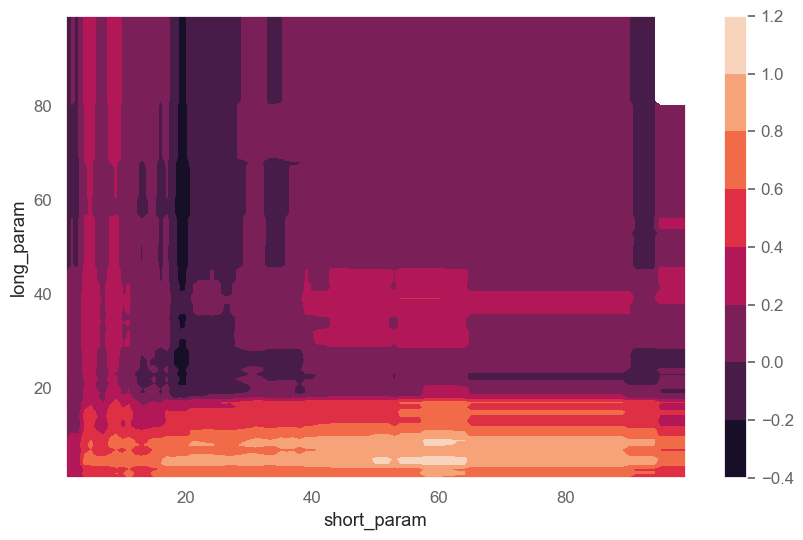

In [25]:
import numpy as np
import matplotlib.pyplot as plt
param_plot(results_df,['long_param','short_param'],'sharpe')

In [28]:
pf.returns()

2007-07-02    0.000000
2007-07-03    0.009730
2007-07-04    0.010523
2007-07-05   -0.002521
2007-07-06    0.008791
                ...   
2023-07-14    0.000871
2023-07-17    0.006035
2023-07-18   -0.002942
2023-07-19   -0.015445
2023-07-20    0.000000
Length: 3955, dtype: float64

c:\Users\Austin\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Austin\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Austin\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2007-07-03   2007-07-03
End Period                 2023-07-20   2023-07-20
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       60.0%

Cumulative Return          88.57%       903.81%
CAGR﹪                     2.76%        10.42%

Sharpe                     0.3          1.16
Prob. Sharpe Ratio         88.04%       100.0%
Smart Sharpe               0.28         1.1
Sortino                    0.41         1.76
Smart Sortino              0.39         1.67
Sortino/√2                 0.29         1.24
Smart Sortino/√2           0.28         1.18
Omega                      1.31         1.31

Max Drawdown               -60.55%      -21.71%
Longest DD Days            2732         693
Volatility (ann.)          21.1%        13.43%
R^2                        0.06         0.06
Information Ratio          0.03         0.03
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-12-19,2020-03-18,2020-07-01,196,-21.705475,-18.416374
2,2018-01-23,2019-01-02,2019-12-16,693,-15.869999,-14.976862
3,2011-02-08,2011-12-16,2012-01-31,358,-11.702964,-10.352695
4,2021-08-20,2022-08-09,2022-11-22,460,-11.213164,-10.108851
5,2012-03-02,2012-07-24,2012-09-11,194,-10.079552,-9.404131


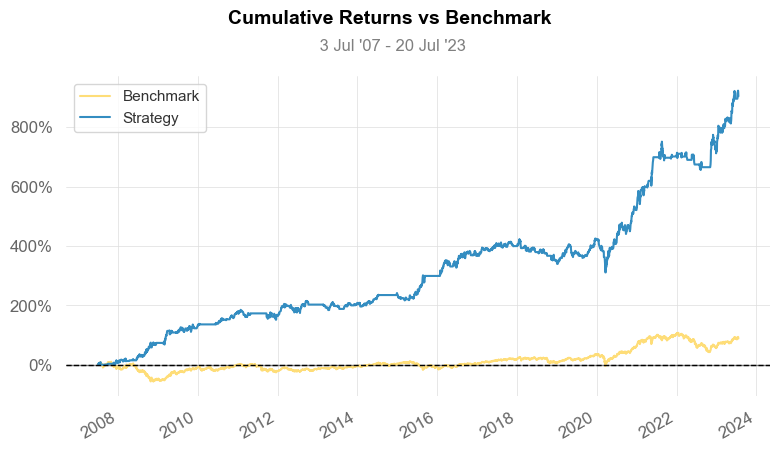

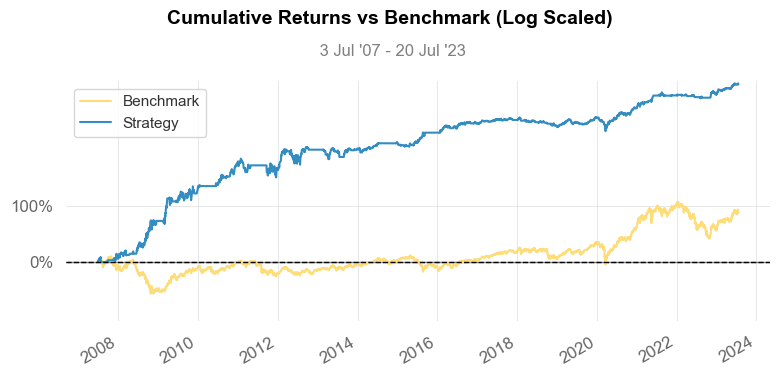

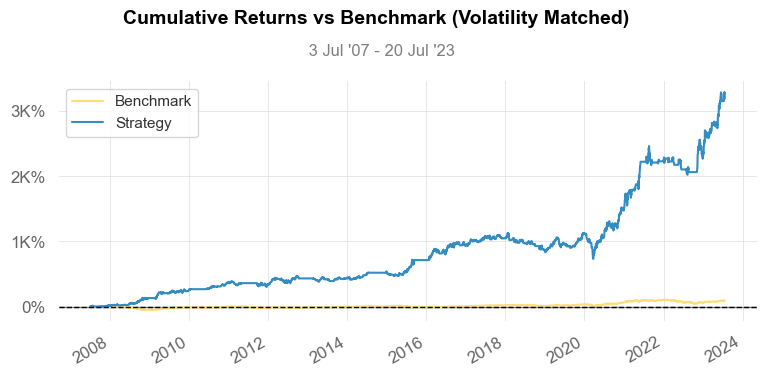

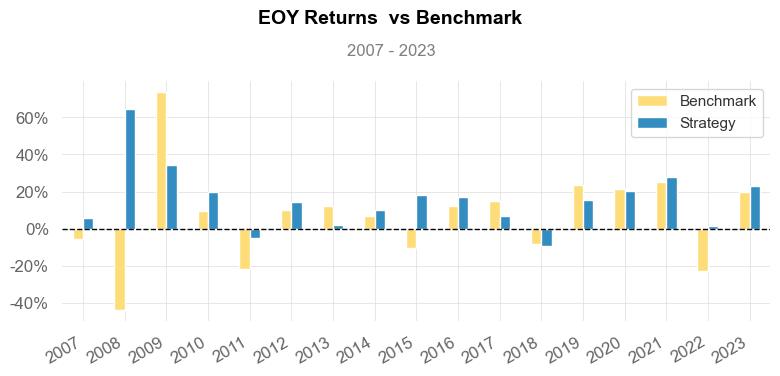

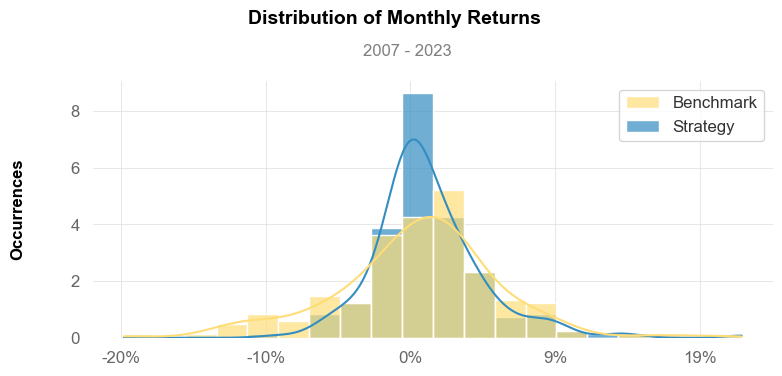

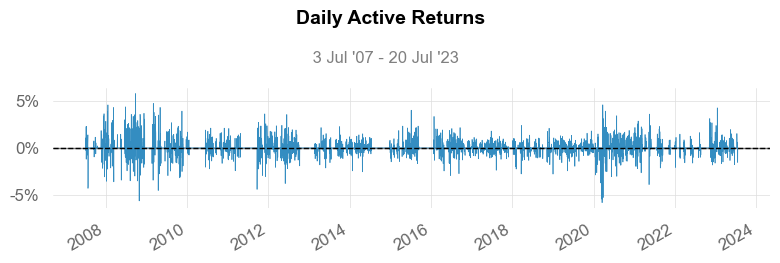

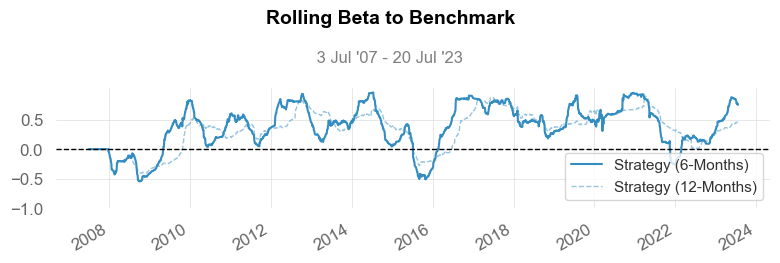

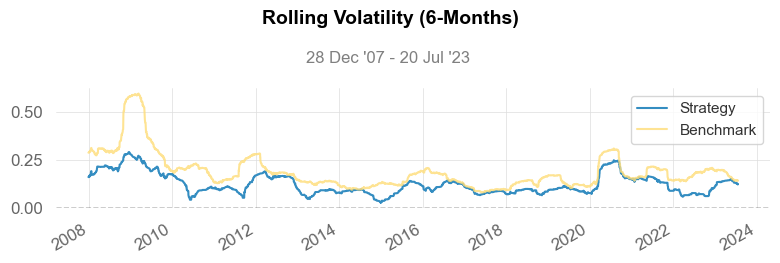

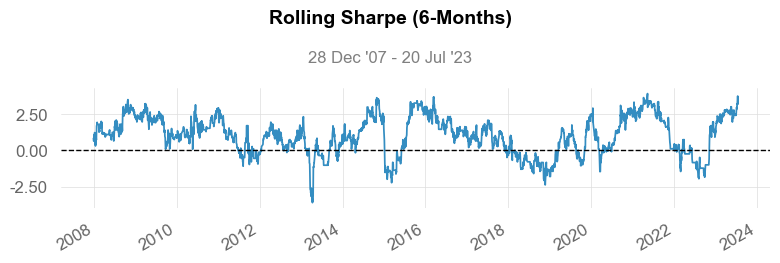

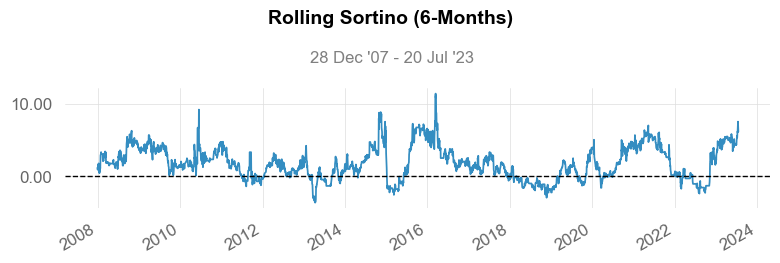

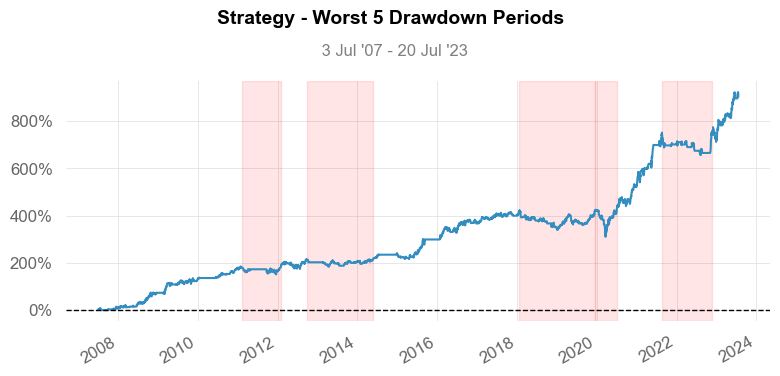

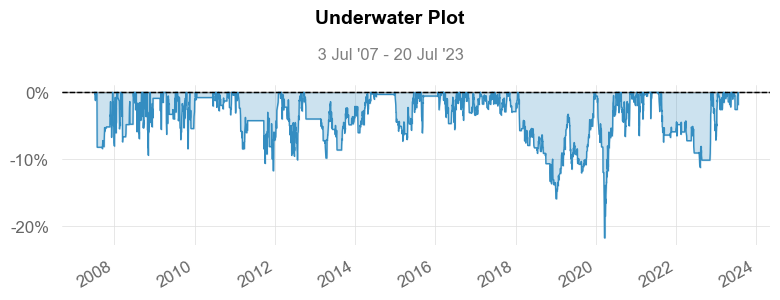

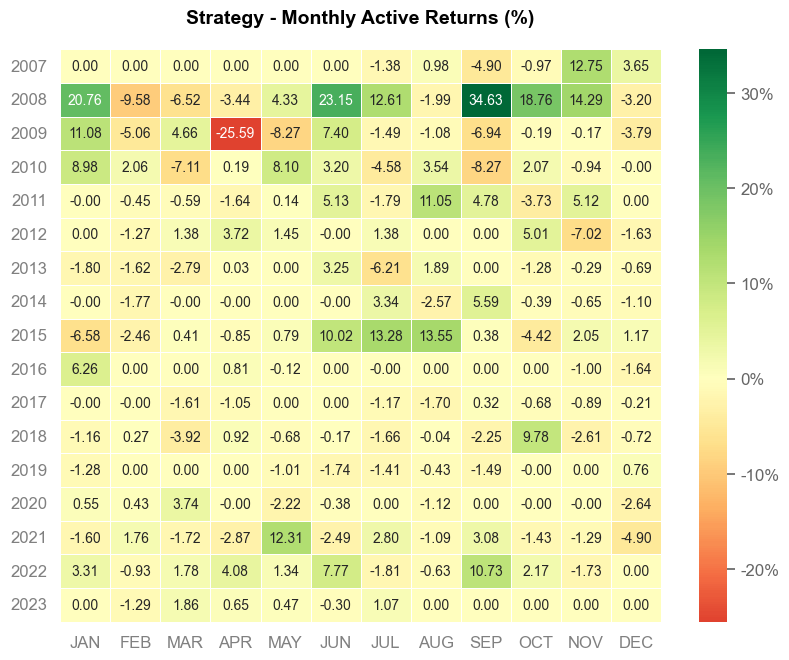

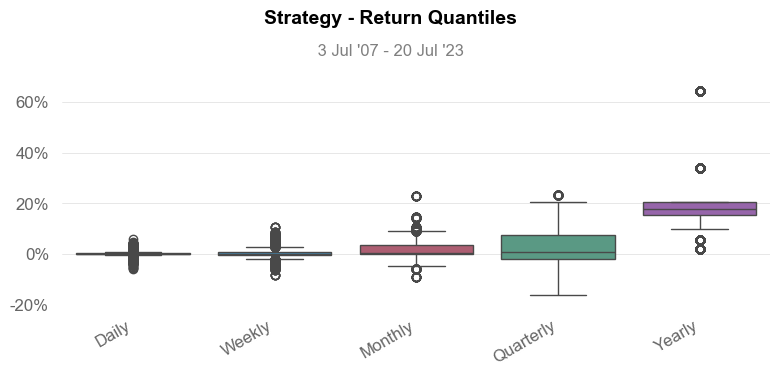

In [26]:
entry_price = open_price.shift(-1)
pf = vbt.Portfolio.from_signals(entry_price.loc[小台散戶多空比.index],
                                    entries = 小台散戶多空比 < -0.05,
                                    exits = 小台散戶多空比 > 0.05,
                                    short_entries = 小台散戶多空比 > 0.58,
                                    short_exits = 小台散戶多空比 < -0.58
                                       )
qs.reports.full(pf.returns(),entry_price.loc[小台散戶多空比.index].pct_change())